I developed this notebook as a walk-through a relatively basic convolutional neural network for producing bounding boxes for a shape in an image.  For this problem I have an accompanying notebook (trainImgGen) that produces a set of images to train and test our network with.  Remember that the purpose of this neural network is to "look" at an image and produce four outputs: the (x,y) coordinate for the bounding boxes top left corner as well as the width and height of the bounding box.

In [1]:
#These statements import the different layers, utilities, etc that we need from Keras.
import keras
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dense, Input
from keras.optimizers import Adam
from keras.utils import to_categorical

#These libraries are used for plotting our predictions at the end of this notebook.
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

#Numpy is a very popular library for many reason but we'll use its arrays in this notebook.  
#You'll notice that numpy as refered to as "np" for the rest of the notebook.
import numpy as np

#A couple other libraries that we'll need
import os
import random

Using TensorFlow backend.


In [2]:
#This block of code is mostly here to allow the GPU (the hardware that speeds up the neural network training)
#to be shared between computers.  This is all backend stuff that you don't necessary need to worry about.
import tensorflow as tf
from keras import backend as k
 
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

The block below is where we will import all of the training images that were created in the trainImgGen notebook. An important idea that you need to understand is that images can be loaded in an array structure where each element (number in the array) is a "color" value of the corresponding pixel.  A simple black-and-white 12 pixel by 12 pixel image could be represented by a 12x12 matrix (called an array in python) where each element is a 1 or 0 (black or white).  

If we look at a 12x12 pixel RGB (red-blue-green) image we would have an array that's not just 12x12 but 12x12x3.  The three comes from having a seperate matrix for the red channel, the green channel, and the blue channel.  For each of these color channels you will see numbers between 0 and 255.  

The images created by the trainImgGen notebook are RGB images so, even though they are black and white, when we import them here they will come in as arrays of size 12x12x3.  You will also see that we are importing the coordinates of the top corner, width, and height of the black box in each image so we have a "labeled" dataset to train our network with. 

In [3]:
#Create a blank list to store the image arrays.
imgList = []
#Iterate through all .png files in this folder.
for file in os.listdir("trainImages"):
    if file.endswith(".png"):
        filename = 'trainImages/' + file
        #import the image as an array
        imgArr = np.array(Image.open(filename))
        #the new few lines are all for pulling out the box coordinates, width, and height
        #find the '-' in the filename so we can parse out what we need
        locString = file[file.index('-')+1:file.index('-')+5]
        topCornerX = int(locString[0])
        topCornerY = int(locString[1])
        boxWidth = int(locString[2])
        boxHeight = int(locString[3])
        #append this image's array, top corner coordinates, width and height to our imgList list
        imgList.append((imgArr, topCornerX, topCornerY, boxWidth, boxHeight))

#we pull out our image width, height, and number of channels (3 for our images) to use these measurements later
#this line just pulls out the first image's array and gets the shape of it
imgWidth = imgList[0][0].shape[1]
imgHeight = imgList[0][0].shape[0]
imgChannel = imgList[0][0].shape[2]
#this gives us the total number of images we imported
numImg = len(imgList)

In [4]:
#I've included this to show you an example of one of the image arrays and 
#how the top corner coordinates, width and height are stored in the list.
print(imgList[0])

(array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255,

The next few blocks are to set up our train/test split.  We want to train the network on a set of labeled examples and then "test" it on some that it didn't see during training.  One important fact here is that python is "zero indexed" meaning the first element in a list, array, etc. is at 0 (not 1 like some other languages).

In [5]:
#This is set up for a 80/20 train/test split.  This first line just gets the number of lines we'll split off
#for the "train" set of data.
splitRow = int(0.80 * len(imgList))
#We want this to be a random split so we shuffle the "rows" of the list.
random.shuffle(imgList)
#The training data is from row 0 to splitRow and the testing is from splitRow to the end.
train_data = imgList[:splitRow]
test_data = imgList[splitRow:]

In [6]:
#In this block I'm going to take the train_data list and form into in a numpy array because that is
#the form Keras expects to see our data in.
trainSize = len(train_data)

#This says that the "x" or predictor (the array of each image) for our training is the first element of each row in our list.
train_X = [data[0] for data in train_data]

#This says that the "y" or response (the corner coords, width, and height) are elements one through five of each row in our list.
train_Y = [data[1:5] for data in train_data]

#This looks confusing but this is where we take our list and make it into an numpy array.  We're doing something called
#"list comprehension" here because we need to pull out the actual array in each row of the train_X list.  Each array (image)
#is then "vertically" stacked in our new array and then the array is reshaped into the four dimensions that keras needs it in
#for our convolutional layer.
train_XArr = np.array([np.vstack(X) for X in train_X]).reshape(trainSize, imgHeight, imgWidth, imgChannel)

#A similar thing is happening here with the reponse values as we shape them into the array we needs for our training.
train_YInt = np.array([np.vstack(Y) for Y in train_Y]).reshape(trainSize, 4)

This next step is very important but may not be immediately obvious but is vital to producing a good neural network.  Neural networks are much better at dealing providing predictions of whether or not something belongs to a certain class instead of providing a definite yes or no. You can absolutely force them into making predictions of ones or zeros but it can significantly hamper your training so, in a problem like we have here, we generally set up our output layer to be a percentage prediction that our output belongs to a set of categories. 

If our images are 12x12 then we will have an output layers that are 12 nodes wide where each node will be a percentage that the prediction belongs to that category.  For instance, if our bounding box coordinates for a particular image are (2,3) then we'd hope to see one of the outputs of our network (the one for the x-coordinate) be something like 
```text
[0.001, 0.001, 0.989, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
```
Here you can see that all of the categories add up to one (more on that later) and that the highest prediction is in the third place which would correspond to the second pixel ([pixel 0, pixel 1, pixel 2,...]) or a prediction that the x-coordinate for the top corner of our bounding box is 2.

Hopefully this helps explain why we have the code in the block below which takes our four numbers (x,y,width,height) and makes them into what is called a "one-hot" vector (where every element except one is a zero).

In [7]:
train_YArr = to_categorical(train_YInt, num_classes=max(imgWidth, imgHeight))

In [8]:
#This cell is here to demonstrate an example of the one-hot encoding.
print("X-coordinate:",train_YInt[0,0])
print("One-hot vector:",train_YArr[0,0])

X-coordinate: 7
One-hot vector: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [9]:
#This block is an exact copy of what we did with the train_data 
testSize = len(test_data)
test_X = [data[0] for data in test_data]
test_Y = [data[1:5] for data in test_data]
test_XArr = np.array([np.vstack(X) for X in test_X]).reshape(testSize, imgHeight, imgWidth, imgChannel)
test_YInt = np.array([np.vstack(Y) for Y in test_Y]).reshape(testSize, 4)
test_YArr = to_categorical(test_YInt, num_classes=max(imgWidth, imgHeight))

In [10]:
#I stole this from someone else but it just uses Keras' callbacks to produce a graph of the losses during training.
#You'll see this graph below.
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [11]:
#Here we're setting the input shape of the network as (imgWidth, imgHeight, imgChannels).
input_shape = tuple(list(train_XArr.shape)[1:])

There are two model building APIs in Keras: sequential and functional.  Most introductory projects you'll find
on the internet are going to use the sequential because it's easier to understand (you add layers one-by-one to your network).  Because we require four outputs from our network, we needed to use the more advanced functional API.  I just want to warn you in case you see something different when looking around on the internet. 

In the cell below you will see that the layers are added in this general form:
LayerName = TypeOfLayer(attributes)(LayerFeedingThisLayer)

For this introduction I've built about the most basic network I could that would perform reasonably well. It consists of an input layer, a single convolutional layer, a flattening layer (for reshaping the output of the convolutional layer), and finally four output layers so we can get the four predictions we need.

You'll notice that in a lot of this code I reference different parts of the "shape" method of various arrays.  It's good practice to do this instead of hard-coding numbers because it provides some flexibility should you want to change image size or other aspects of your inputs or outputs. 

The Conv2D layer below is the most important of this small network and is, obviously, a convolutional layer. The first attribute in this network is the number of filters to apply to our image.  These filters are relatively small matrices who elements are randomly generated.  These filters are also called kernels and the next attribute "kernel_size" gives the size of each of these kernels or filters. I don't want to recreate a complete intro to convolutional neural networks here so hopefully you can find some more intro material elsewhere.  I mentioned these attributes here to encourage you to change the number, recompile, and retrain the network to see the comparative success of smaller networks. 

In [12]:
inputs = Input(shape=input_shape)
conv1 = Conv2D(12, kernel_size=(3, 3), strides=(1, 1),
                 activation='sigmoid',
                 input_shape=input_shape,
                    data_format='channels_last')(inputs)
flat = Flatten()(conv1)

#You'll the activation function for each of the output layer is "softmax". This activation forces all of the 
#values in each node across each layer to add up to one... which is handy if you are looking for percentages.
topX = Dense(train_YArr.shape[2], activation='softmax')(flat)
topY = Dense(train_YArr.shape[2], activation='softmax')(flat)
width = Dense(train_YArr.shape[2], activation='softmax')(flat)
height = Dense(train_YArr.shape[2], activation='softmax')(flat)

#This last line actually builds the model by identifying the input layer and output layers.
model = Model(outputs = [topX, topY, width, height], inputs = inputs)

W0717 12:37:27.835039 140639173166912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 12:37:27.835831 140639173166912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 12:37:27.840238 140639173166912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [13]:
#The compile method sets the loss function as well as optimizer.  Because we are making a categorical prediction we want
#to use one of the keras' categorical loss function. Understanding these things any further is beyond the scope of this
#introduction.
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001))

#This summary is useful in establishing exactly how the inputs and outputs of various model layers are shaped as well
#as how many trainable parameters (parameters that will be modified during training) are in the model. 
model.summary()


W0717 12:37:27.911499 140639173166912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0717 12:37:27.919362 140639173166912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 12, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 12)   336         input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1200)         0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           14412       flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (D

The "fit" method is where we actuall train the model.  You can see that the first attribute is our training predictors
(the images in the train dataset) and the second attribute is a list of the four responses (x,y,width,height).  When we are doing supervised training we provide the network with predictors and responses so it can calculate the difference between what it predicted and the actual value.  It will use this difference to improve future predictions.  I also provide it with the the test dataset as "validation_data" so it can give us some indication of how it is performing on data it hasn't trained on.  

There are a couple more important attributes here including "epochs" and "batch_size" which will require some external research.  Briefly, the batch_size represents how many samples (images) we push through the network during one training cycle.  Remember training neural networks is really a big matrix algebra problem so we just make the matrices bigger when we have bigger batch_sizes.  Epochs are the number of times that each sample in our training dataset will be seen by the network.

Once you start training the graph I mentioned below will appear and you'll be able to track the losses as the network improves its ability to make prediction.  We want to see a relatively smooth decreasing function for both the loss and val_loss here.  Occasionally we will see a jump of the loss as the algorithm makes a "mistake" in optimizing the network's parameters.  

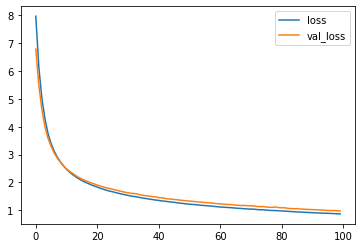

In [14]:
model.fit(train_XArr, [train_YArr[:,0],train_YArr[:,1],train_YArr[:,2],train_YArr[:,3]],
          validation_data = (test_XArr, [test_YArr[:,0],test_YArr[:,1],test_YArr[:,2],test_YArr[:,3]]),
          epochs=100, verbose=0, batch_size=500, callbacks=[plot_losses])

This last bit of code here is just to provide you with some indication of what we've been doing above.  It will pull a random image from the test dataset, reshape it to push into the network, and finally use the network to make a prediction of the x, y, width, and height of the bounding box for the black shape in the image.

Shift-Enter the cell below several times to see different examples of how well the network works. 

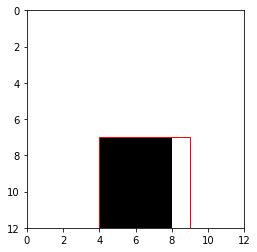

In [18]:
#Get a random image number for an image in our test dataset
imgNum = np.random.randint(0, test_XArr.shape[0])

#Reshape that image array to it'll go into the network
testPredImg = test_XArr[imgNum].reshape(1,test_XArr.shape[1],test_XArr.shape[2],test_XArr.shape[3])

#Make the prediction
prediction = model.predict(testPredImg)

#Getting the column number highest percentage (argmax) of each output layer
predCoords = np.argmax(prediction, axis=2).flatten()

#Make an image from the array we just pushed into the network
img = Image.fromarray(test_XArr[imgNum])

#Some matplotlib code
fig,ax = plt.subplots(1)

#Plot our test image that we just pushed into the network
plt.imshow(img, origin='upper', extent=[0,imgWidth,imgHeight,0])

#Add a red rectangle where the network predicted the bounding box should be
ax.add_patch(patches.Rectangle((predCoords[0],predCoords[1]),
                                    (predCoords[2]),
                                    (predCoords[3]), 
                                    fill=False, color='red'))

As a final note, you will find several instances where the network doesn't do very well predicting the bounding box (especially when the shape is on the edge of the image).  Some of this due to requiring more training and a bigger training dataset but some of it is just due to the relative simplicity of our neural network.  No doubt any network you build for your projects will need to be substantially more complicated. 